In [1]:
import os
import json

import torch

from stnn import SaptioTemporalNN
from utils import rmse
from datasets import dataset_factory

import matplotlib.pyplot as plt
%matplotlib inline

## Data

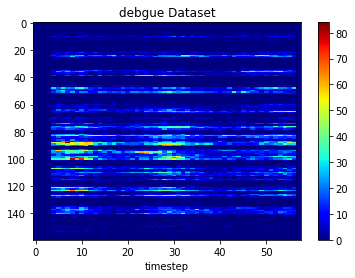

In [20]:
datadir = 'data'
dataset = 'dengue'
_, (train_data, test_data), _ = dataset_factory(datadir, dataset)

plt.figure('dengue dataset')
plt.imshow(torch.cat((train_data, test_data)).squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('debgue Dataset')
plt.xlabel('timestep')
plt.colorbar()

## Training

In [3]:
run train_stnn.py --dataset dengue --outputdir output_heat --manualSeed 2021 --xp stnn

100%|██████████| 10000/10000 [10:47<00:00,  7.94it/s, loss=0.0158, rmse_test=3.36]


<Figure size 432x288 with 0 Axes>

In [6]:
run train_stnn.py --dataset dengue --outputdir output_heat --manualSeed 5718 --xp stnn_r --mode refine --patience 800 --l1_rel 1e-8

100%|██████████| 10000/10000 [23:50<00:00,  3.34it/s, loss=0.0151, rmse_test=3]  


In [7]:
run train_stnn.py --dataset dengue --outputdir output_heat --manualSeed 9690 --xp stnn_d --mode discover --patience 1000 --l1_rel 3e-6

100%|██████████| 10000/10000 [27:56<00:00,  2.88it/s, loss=0.0134, rmse_test=3.27]


## Model

In [8]:
outputdir = 'output_heat'
exps = ['stnn', 'stnn_r', 'stnn_d']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_data, test_data), relations = dataset_factory(datadir, dataset, config['khop'])

    model = SaptioTemporalNN(relations, 160, 53, 1, config['nz'], config['mode'], config['nhid'],
                             config['nlayers'], config['dropout_f'], config['dropout_d'],
                             config['activation'], config['periode'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

## Results

In [15]:
predictions = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction, _ = model.generate(5)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
    print('RMSE {}:\t'.format(exp), mse)

RMSE stnn:	 3.3633546829223633
RMSE stnn_r:	 3.0018491744995117
RMSE stnn_d:	 3.2742719650268555


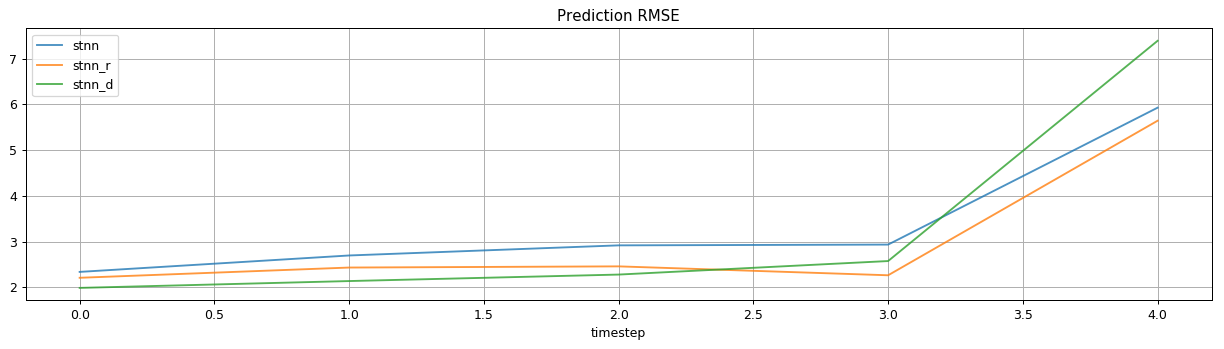

In [17]:
plt.figure('Test plots', figsize=(17, 4), dpi=90)
for exp in exps:
    with open(os.path.join(outputdir, exp, 'logs.json'), 'r') as f:
        logs = json.load(f)

    plt.plot([logs['test_epoch.ts.{}.rmse'.format(ts)][-1] for ts in range(5)], label=exp, alpha=0.8)

plt.grid()
plt.title('Prediction RMSE')
plt.xlabel('timestep')
plt.legend()

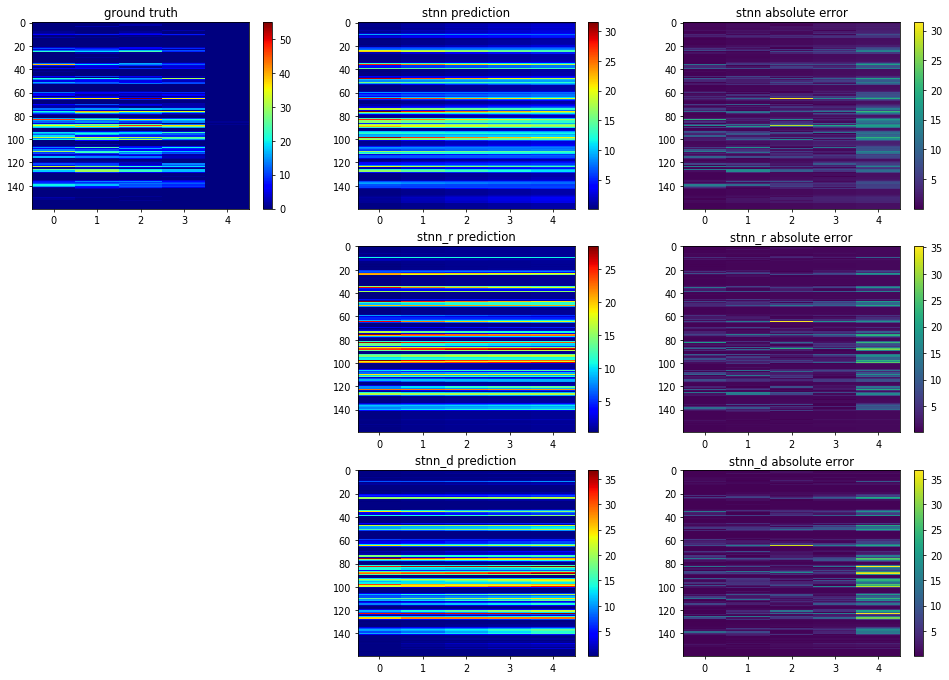

In [18]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(exps):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(predictions[exp].squeeze().numpy().T, aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(test_data.sub(predictions[exp]).abs().squeeze().numpy().T, aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))

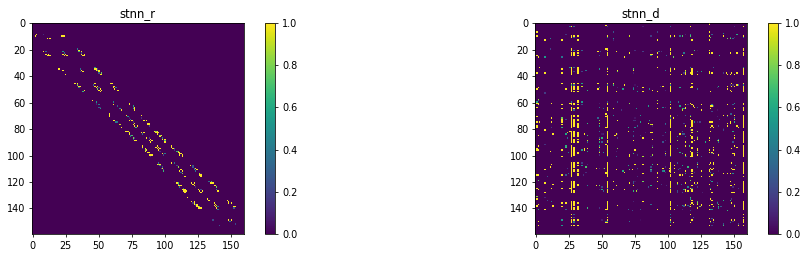

In [19]:
plt.figure('Relations', figsize=(17, 4), dpi=70)

plt.subplot(1, 2, 1)
m = models['stnn_r']
plt.imshow(m.get_relations()[:, 1].detach().numpy(), aspect='equal')
plt.title('stnn_r')
plt.colorbar()

plt.subplot(1, 2, 2)
m = models['stnn_d']
plt.imshow(m.get_relations()[:, 1].detach().numpy(), aspect='equal')
plt.title('stnn_d')
plt.colorbar()